In [19]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
from dnnbrain.io.fileio import ActivationFile
from activation_PSI import Dnn_act, sparseness
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [28]:
# specify custom paremeters
root = os.getcwd() # root directory of analysis
net = 'alexnet' # ['alexnet', 'vgg11']
dataset = 'caltech256'  # make sure you have run 01 & 02 with dataset as 'caltech256'

In [29]:
# prepare parameters
stim_per_cat = 80
n_cat = 256
model_method = 'lr' 
cvfold = 2
max_iter = 10000

net_dir = os.path.join(root, net)
caltech256_label = pd.read_csv(os.path.join(root, 'caltech256_label'), sep='\t')
pred_dir = os.path.join(net_dir, 'dnn_prediction')
if os.path.exists(pred_dir) is False:
    os.makedirs(pred_dir)

In [30]:
# load dnn activation
dnnact_path = os.path.join(net_dir, 'dnn_activation', '{0}_{1}.act.h5'.format(net, dataset))
dnnact_alllayer = ActivationFile(dnnact_path).read()
dnnact = np.squeeze(dnnact_alllayer['fc2_relu'])

In [ ]:
# estimate classification performance for each category
n_samp_fold = int(dnnact.shape[0]/cvfold)
n_samp_fold_cat = int(n_samp_fold / n_cat)
X = dnnact.reshape(n_samp_fold, cvfold, -1)
Y_tra = np.asarray([int(i/(stim_per_cat/cvfold*(cvfold-1))) for i
                    in range(int(n_samp_fold*(cvfold-1)))])
Y_test = np.asarray([int(i/(stim_per_cat/cvfold)) for i
                     in range(int(n_samp_fold))])
               
confus = []
for cv in range(cvfold):
    X_tra = np.delete(X, cv, axis=1).reshape(-1, X.shape[-1])
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                               max_iter=max_iter)
    model.fit(X_tra, Y_tra)      

    X_test = X[:, cv, :]
    Y_pred = model.predict(X_test)
    confus.append(confusion_matrix(Y_test, Y_pred))

    print('cv {0} done'.format(cv))
        
confus = np.asarray(confus)  
confus_path = os.path.join(
        pred_dir, '{0}_relu_{1}_multipred_{2}_confus.npy'.format(net, dataset, model_method))
np.save(confus_path, confus)

In [32]:
# load PSI and classification performance
sp = np.load(os.path.join(net_dir, 'PSI_{0}.npy'.format(dataset))) # from 01 & 02 with dataset as 'caltech256'
confus = np.load(confus_path).mean(0)
acc = confus.diagonal()/(confus[0, :].sum())

# layerwise correlation 
acc_sp_corr = [stats.pearsonr(sp[i][~np.isnan(sp[i])], acc[~np.isnan(sp[i])]) for i in range(len(sp))]                            
acc_sp_corr = np.asarray(acc_sp_corr)

tau_corr = stats.kendalltau(np.arange(1, len(sp)+1), acc_sp_corr[:,0])

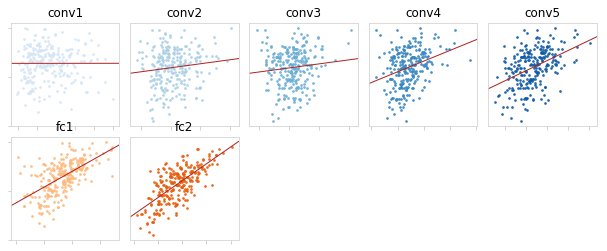

In [33]:
# plot Fig 2
x, y = sp, acc 

conv_colors = sns.color_palette('Blues', n_colors=len(sp[:-2]))
fc_colors = sns.color_palette('Oranges', n_colors=2)
color = np.r_[conv_colors, fc_colors]


plt.figure(figsize = (10.5,4))
gs = gridspec.GridSpec(nrows=2, ncols=5, wspace=0.1, hspace=0.1)

for i in range(len(x)):
    ax = plt.subplot(gs[i])
    sns.regplot(x=x[i], y=y, color=color[i], ci=None,
                scatter_kws={'s':3}, line_kws={'color':'firebrick','linewidth':1, 'linestyle':'-'})

    if np.mod(i,5) == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels([])
    else:
        ax.set_yticks([])
    ax.set_title(list(dnnact_alllayer.keys())[i].split('_')[0])
    ax.set_xticklabels([])        
    ax.set_frame_on(True)  
    ax.tick_params(axis='both', colors='lightgray', width=1, 
                   labelsize=6, labelcolor='gray')
    plt.setp(ax.spines.values(), color='lightgray')